<a href="https://colab.research.google.com/github/MuhammadAhtishamYousaf/LangGraph/blob/main/langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Routing

In [9]:
!pip install --quiet -U langchain_google_genai langchain_core langgraph

In [10]:
from google.colab import userdata
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI as genai

def multiply_values(a: int, b: int) -> int:
    """Multiply two values
    Args:
    a: first int
    b: second int
    Returns:
    a * b
    """
    return a * b


In [13]:
llm=genai(model='gemini-1.5-flash',api_key=GEMINI_API_KEY)


In [14]:
llm_with_tool_bind=llm.bind_tools([multiply_values])

In [7]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START,END
from langgraph.graph import MessagesState # Make sure MessagesState is imported correctly
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph.state import CompiledStateGraph

#node function

def tool_calling_with_llm(state: MessagesState): # Specify the type of the argument
    # Access the messages using state['messages']
    return {"messages":llm_with_tool_bind.invoke(state['messages'])}

#build graph
builder:StateGraph=StateGraph(MessagesState)
builder.add_node("tool_calling_with_llm",tool_calling_with_llm)
builder.add_node("tools",ToolNode([multiply_values]))

#Edges
builder.add_edge(START,"tool_calling_with_llm")
builder.add_conditional_edges(
    "tool_calling_with_llm",
    #if the llm response is a tool call -> tools condition will be towards tools
    #if the llm response is natural language, tools condition will be towards end
    tools_condition
)

builder.add_edge("tools",END)

graph: CompiledStateGraph=builder.compile()

# display
display(Image(graph.get_graph().draw_mermaid_png()))

NameError: name 'multiply_values' is not defined

In [8]:
from langchain_core.messages import HumanMessage, SystemMessage
messages = [SystemMessage(content="You are a helpfull assistant.") , HumanMessage(content="Multiply 5 with 5")]
messages = graph.invoke({"messages": messages})
print(messages)
for m in messages['messages']:
    m.pretty_print()

NameError: name 'graph' is not defined

# Memory


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = GEMINI_API_KEY)
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState) -> MessagesState:
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# assistant({"messages": [HumanMessage(content="What is 2 + 2")]})
# assistant(MessagesState({"messages": [HumanMessage(content="What is 2 + 2")]}))

In [ ]:
# LANGSMITH_TRACING=True
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY=userdata.get('LANGSMITH_API_KEY')
LANGSMITH_PROJECT="pr-new-mesenchyme-9"

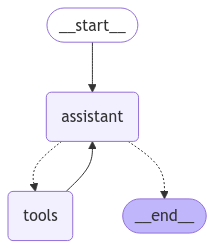

In [ ]:
from langgraph.graph import START,END, StateGraph
from langgraph.prebuilt import ToolNode,tools_condition
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Graph
builder=StateGraph(MessagesState)

# Nodes
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

# Define Edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
# if the response is a tool call,tools_condition moves to tools
#if the response is message,tools condition moves to end
builder.add_edge("tools","assistant")

ReAct_graph:CompiledStateGraph=builder.compile()
display(Image(ReAct_graph.get_graph().draw_mermaid_png()))

## Invoking the Graph

In [ ]:
messages=[HumanMessage(content='Add 3 and 4')]
messages=ReAct_graph.invoke({"messages":messages})
print(messages)
for m in messages['messages']:
    m.pretty_print()

{'messages': [HumanMessage(content='Add 3 and 4', additional_kwargs={}, response_metadata={}, id='933224c3-c947-4ff2-9f24-b45b2214fe1c'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 3.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-4ffe9195-f091-45b5-a133-9c46a3dd31b4-0', tool_calls=[{'name': 'add', 'args': {'a': 3.0, 'b': 4.0}, 'id': 'fd22b017-43d8-424e-962a-34794cd1b484', 'type': 'tool_call'}], usage_metadata={'input_tokens': 63, 'output_tokens': 3, 'total_tokens': 66, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='7', name='add', id='0f33cf1b-e51e-4240-90b3-f54f4c2df13e', tool_call_id='fd22b017-43d8-424e-962a-34794cd1b484'), AIMessage(content='The sum of 3 and 4 is 7.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings'

In [ ]:
messages=[HumanMessage(content='Multiply that by 2')]
messages=ReAct_graph.invoke({"messages":messages})
print(messages)
for m in messages['messages']:
    m.pretty_print()

{'messages': [HumanMessage(content='Multiply that by 2', additional_kwargs={}, response_metadata={}, id='e29a70d3-4f35-4811-a172-109e8a083b5b'), AIMessage(content='What values would you like me to multiply by 2?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-7b79a784-816b-4113-bcc5-2bf499682191-0', usage_metadata={'input_tokens': 62, 'output_tokens': 12, 'total_tokens': 74, 'input_token_details': {'cache_read': 0}})]}
================================ Human Message =================================

Multiply that by 2
================================== Ai Message ==================================

What values would you like me to multiply by 2?


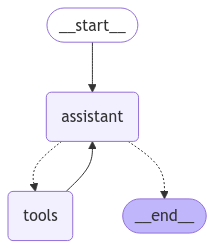

In [ ]:
from langgraph.graph import START,END, StateGraph
from langgraph.prebuilt import ToolNode,tools_condition
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver

# Graph
builder=StateGraph(MessagesState)

# Nodes
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

# Define Edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
# if the response is a tool call,tools_condition moves to tools
#if the response is message,tools condition moves to end
builder.add_edge("tools","assistant")

memory_saver:MemorySaver=MemorySaver()
ReAct_graph_memory:CompiledStateGraph=builder.compile(checkpointer=memory_saver)

display(Image(ReAct_graph_memory.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable":{"thread_id":"1"}}

message=HumanMessage(content="Add 2 and 3")

response=ReAct_graph_momory.invoke({"messages":message},config)
print(response)
for i in response['messages']:
    i.pretty_print()

{'messages': [HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='ebbc6a01-92c1-4a64-849f-cdbfd14d1b2a'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-6b71916b-c46a-415d-96c0-148c115b3360-0', tool_calls=[{'name': 'add', 'args': {'a': 2.0, 'b': 3.0}, 'id': '8fb1ca6b-6290-444c-b756-53e91c181361', 'type': 'tool_call'}], usage_metadata={'input_tokens': 63, 'output_tokens': 3, 'total_tokens': 66, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='5', name='add', id='229eb4b6-af3f-44d2-a272-9e5e0a31bf1d', tool_call_id='8fb1ca6b-6290-444c-b756-53e91c181361'), AIMessage(content='The sum of 2 and 3 is 5.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings'

In [ ]:
config = {"configurable":{"thread_id":"1"}}
message=HumanMessage(content="multiply that by 3")

response=ReAct_graph_memory.invoke({"messages":message},config)
print(response)
for i in response['messages']:
    i.pretty_print()

{'messages': [HumanMessage(content='multiply that by 3', additional_kwargs={}, response_metadata={}, id='976a6558-0633-4a37-a311-039d3ec99efa'), AIMessage(content='What values would you like me to multiply by 3?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-9d49ad5d-34b7-4b35-be39-be4636de5513-0', usage_metadata={'input_tokens': 62, 'output_tokens': 12, 'total_tokens': 74, 'input_token_details': {'cache_read': 0}})]}
================================ Human Message =================================

multiply that by 3
================================== Ai Message ==================================

What values would you like me to multiply by 3?


## Deployment

# Module 2

In [ ]:
from pydantic import BaseModel, field_validator, ValidationError
from typing import Literal
class PydanticState(BaseModel):
    name:str
    mood:Literal["sad","happy"]
    @field_validator("mood")
    def mood_must_be_sad_or_happy(cls,value):
        if value not in ["sad","happy"]:
            raise ValueError("mood must be sad or happy")
        return value

try:
    state=PydanticState(name="Ahtisham",mood="sad")
    print(state)
except ValidationError as e:
    print(e)


name='Ahtisham' mood='sad'


In [ ]:
from langgraph.graph import START,END, StateGraph
from langgraph.prebuilt import ToolNode,tools_condition
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

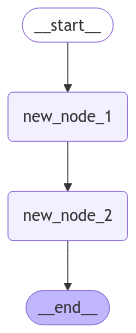

In [ ]:
def new_node_1(state:PydanticState):
    print("___node___1")
    return {"name":"I am" + state.name}

def new_node_2(state:PydanticState):
    print("___node___2")
    return {"mood":"My mood is" + state.mood}


builder_workflow=StateGraph(PydanticState)
builder_workflow.add_node("new_node_1",new_node_1)
builder_workflow.add_node("new_node_2",new_node_2)

builder_workflow.add_edge(START,"new_node_1")
builder_workflow.add_edge("new_node_1","new_node_2")
builder_workflow.add_edge("new_node_2",END)

graph:CompiledStateGraph=builder_workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"name":"ahtisham","mood":"sad"})

___node___1
___node___2


{'name': 'I amahtisham', 'mood': 'My mood issad'}

## Pydantic ReAct Agent

In [ ]:
from langchain_core.tools import tool
llm=genai(model='gemini-1.5-flash',api_key=GEMINI_API_KEY)
@tool
def search(query: str) -> str:
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return "The answer to your question lies within."

tools=[search]

In [ ]:
from langgraph.prebuilt import ToolNode
tool_node=ToolNode(tools)

In [ ]:
llm_with_tool_bind=llm.bind_tools(tools)

In [ ]:
import operator
from typing import Annotated, Sequence
from langchain_core.messages import BaseMessage
from pydantic import BaseModel

class AgenticState(BaseModel):
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [ ]:
from typing import Literal
model=llm.bind_tools(tools)
def should_continue(state:AgenticState) -> Literal["end","continue"]:
    messages=state.messages
    last_messasge=messages[-1]

    if not last_messasge.tool_calls:
        print("last_message.tool_call")
        return "end"
    else:
        print("continue else case")
        return "continue"

def call_model(state:AgenticState):
    response=model.invoke(state.messages)
    return {"messages":[response]}

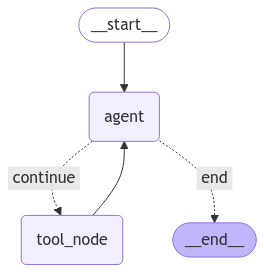

In [ ]:
from langgraph.graph import START,END, StateGraph
from IPython.display import Image, display
# from langgraph.graph.state import CompiledStateGraph
#define new graph
workflow=StateGraph(AgenticState)
workflow.add_node("agent",call_model)
workflow.add_node("tool_node",tool_node)

workflow.add_edge(START,"agent")
workflow.add_conditional_edges("agent",should_continue,{"continue":"tool_node","end":END})

workflow.add_edge("tool_node","agent")

graph:CompiledStateGraph=workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
from langchain_core.messages import HumanMessage
inputs={"messages":[HumanMessage(content="what is the weather in sf?")]}
for chunk in graph.stream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what is the weather in sf?
last_message.tool_call
================================== Ai Message ==================================

I am sorry, I cannot fulfill this request. The available tools lack the desired functionality.


# State Reducers

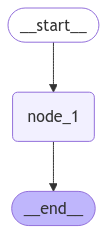

{'foo': 1}

In [ ]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph,START,END
from langgraph.graph.state import CompiledStateGraph

class TypeDictState(TypedDict):
    foo:int

def node_1(state:TypeDictState):
    return {"foo":state["foo"]+1}

# def node_2(state:TypeDictState):
#     return {"foo":state["foo"]+2}

builder=StateGraph(TypeDictState)
builder.add_node("node_1",node_1)

builder.add_edge(START,"node_1")
builder.add_edge("node_1",END)

graph:CompiledStateGraph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo":0,"user":"me"})

### branches

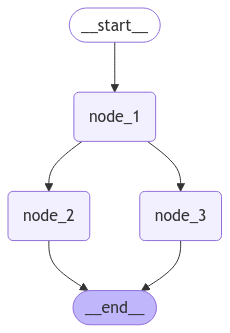

InvalidUpdateEror: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


In [ ]:
class TypeDictState(TypedDict):
    foo:int

def node_1(state:TypeDictState):
    return {"foo":state["foo"]+1}

def node_2(state:TypeDictState):
    return {"foo":state["foo"]+2}

def node_3(state:TypeDictState):
    return {"foo":state["foo"]+3}

builder=StateGraph(TypeDictState)
builder.add_node("node_1",node_1)
builder.add_node("node_2",node_2)
builder.add_node("node_3",node_3)

builder.add_edge(START,"node_1")
builder.add_edge("node_1","node_2")
builder.add_edge("node_1","node_3")
builder.add_edge("node_2",END)
builder.add_edge("node_3",END)

graph:CompiledStateGraph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo":0})
except InvalidUpdateError as e:
    print(f"InvalidUpdateEror: {e}")

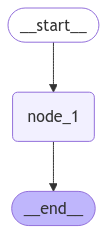

___node___1


{'foo': [2, 3]}

In [ ]:
from operator import add
from typing import Annotated

class StateAnotated(TypedDict):
    foo: Annotated[list[int],add]

def node_1(state:StateAnotated):
    print("___node___1")
    return {"foo":[state["foo"][0]+1]}

builder=StateGraph(StateAnotated)

builder.add_node("node_1",node_1)

builder.add_edge(START,'node_1')
builder.add_edge("node_1",END)

graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo":[2]})

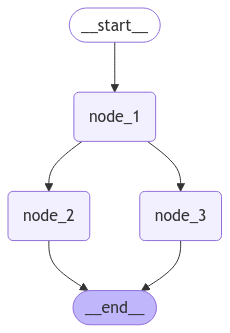

can only concatenate list (not "NoneType") to list


In [ ]:
from logging import exception
class StateAnotated(TypedDict):
    foo: Annotated[list[int],add]

def node_1(state:StateAnotated):
    print("Initial state",state['foo'])
    print("___node___1")
    response={"foo":[state["foo"][-1]+1]}
    print("Node1 response",response)
    return response

def node_2(state:StateAnotated):
    print("___node___2")
    response={"foo":[state["foo"][-1]+1]}
    print("Node2 response",response)
    return response

def node_3(state:StateAnotated):
    print("___node___3")
    response={"foo":[state["foo"][-1]+1]}
    print("Node3 response",response)
    return response

builder=StateGraph(StateAnotated)

builder.add_node("node_1",node_1)
builder.add_node("node_2",node_2)
builder.add_node("node_3",node_3)

builder.add_edge(START,'node_1')
builder.add_edge("node_1",'node_2')
builder.add_edge("node_1",'node_3')
builder.add_edge("node_2",END)
builder.add_edge("node_3",END)

graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

# graph.invoke({"foo":[2]})
try:
    graph.invoke({"foo":None})
except Exception as e:
    print(e)

### Custom Reducers

In [ ]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if left is None:
        left = []
    if not right:
        right = []
    return left + right

# response=reduce_list([1,2],[3,4])
# response=reduce_list([1,2],[3,None])
# response=reduce_list([1,2],[3,''])
# response=reduce_list([1,""],[3,None])
response=reduce_list([1,],[3,None])
print(response)
class DefaultState(TypedDict):
    foo: Annotated[list[int],add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int],reduce_list]

[1, 3, None]


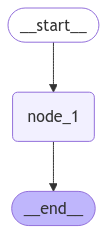

TypeError: can only concatenate list (not "NoneType") to list

In [ ]:
def node_1(state:DefaultState):
    print("___node___1")
    return {"foo":[state['foo']]}

builder=StateGraph(DefaultState)

builder.add_node("node_1",node_1)

builder.add_edge(START,'node_1')
builder.add_edge("node_1",END)

graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo":None})

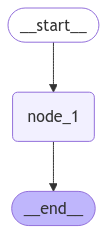

___node___1


{'foo': [[]]}

In [ ]:
def node_1(state:CustomReducerState):
    print("___node___1")
    return {"foo":[state['foo']]}

builder=StateGraph(CustomReducerState)

builder.add_node("node_1",node_1)

builder.add_edge(START,'node_1')
builder.add_edge("node_1",END)

graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo":None})

### Langgraph Reducer

In [ ]:
from typing import Annotated
from langgraph.graph import MessagesState, add_messages
from langchain_core.messages import AnyMessage

# with add_messages reducer
class CustomMessageState(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]
    added_key1:str
    added_key2:str

# with built-in MessagesState
class BuiltInMessageState(MessagesState):
    added_key1:str
    added_key2:str

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage

# initial state
initial_messages=[AIMessage(content='Hello! How can i assist you?',name="Assistant"),
                  HumanMessage(content="What is AI Agent?")]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

add_messages(initial_messages,new_message)

[AIMessage(content='Hello! How can i assist you?', additional_kwargs={}, response_metadata={}, name='Assistant', id='562197cd-e9a9-46ef-adc8-c78f5c047475'),
 HumanMessage(content='What is AI Agent?', additional_kwargs={}, response_metadata={}, id='e7d012ad-dd6d-4bb7-90cb-00393d58319b'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

In [ ]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

In [ ]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [ ]:
add_messages(messages,delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

# Multiple Schemas

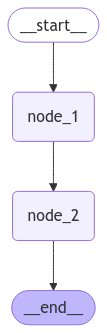

Initial state foo: 1
Initial state buz: 0
___node___1
Node2 response buz: 2
Initial state foo: 1
Initial state buz: 2
___node___2
Node2 response foo: 3


{'foo': 3, 'buz': 2}

In [ ]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph,START,END
from langgraph.graph.state import CompiledStateGraph

class OverAllState(TypedDict):
    foo:int
    buz:int

def node_1(state:OverAllState) -> OverAllState:
    print(f"Initial state foo: {state['foo']}")
    print(f"Initial state buz: {state['buz']}")
    print("___node___1")
    response={"buz":state["foo"]+1}

    print(f"Node2 response buz: {response['buz']}")
    return response

def node_2(state:OverAllState) -> OverAllState:
    print(f"Initial state foo: {state['foo']}")
    print(f"Initial state buz: {state['buz']}")
    print("___node___2")
    response={"foo":state["buz"]+1}
    print(f"Node2 response foo: {response['foo']}")

    return response

builder:StateGraph=StateGraph(OverAllState)

builder.add_node("node_1",node_1)
builder.add_node("node_2",node_2)

builder.add_edge(START,"node_1")
builder.add_edge("node_1","node_2")
builder.add_edge("node_2",END)

graph:CompiledStateGraph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo": 1,"buz":0})

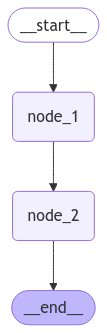

Initial state foo: 1
___node___1
Node2 response buz: 2
Initial state buz: 2
___node___2
Node2 response foo: 3


{'foo': 3}

In [ ]:
class OverAllState(TypedDict):
    foo:int

class PrivateState(TypedDict):
    buz:int

def node_1(state:OverAllState) -> OverAllState:
    print(f"Initial state foo: {state['foo']}")
    print("___node___1")
    response={"buz":state["foo"]+1}

    print(f"Node2 response buz: {response['buz']}")
    return response

def node_2(state:PrivateState) -> PrivateState:
    print(f"Initial state buz: {state['buz']}")
    print("___node___2")
    response={"foo":state["buz"]+1}
    print(f"Node2 response foo: {response['foo']}")

    return response

builder:StateGraph=StateGraph(OverAllState)

builder.add_node("node_1",node_1)
builder.add_node("node_2",node_2)

builder.add_edge(START,"node_1")
builder.add_edge("node_1","node_2")
builder.add_edge("node_2",END)

graph:CompiledStateGraph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo": 1,"buz":0})

In [ ]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph,START,END
from langgraph.graph.state import CompiledStateGraph

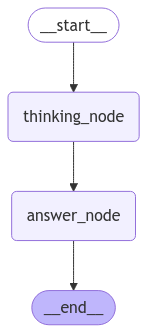

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his is name is Lance'}

In [ ]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState) -> OverallState:
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OverallState:
    return {"answer": "bye Lance"}

graph: StateGraph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph: CompiledStateGraph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke({"question":"hi"})

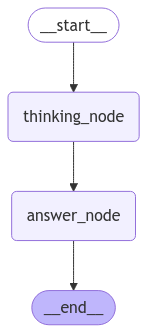

{'answer': 'bye Lance'}

In [ ]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer:str
class OverAllState(TypedDict):
    question:str
    answer:str
    notes:str

def thinking_node(state: OverallState) -> OverallState:
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OverallState:
    return {"answer": "bye Lance"}

graph: StateGraph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph: CompiledStateGraph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke({"question":"hi"})

#Trim & Filter Messages

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages=[AIMessage(f"How can I help you today?", name="Assistant")]
messages.append(HumanMessage(f"I'm looking for information about Agentic AI.One line answer.", name="Lance"))

print(messages)
for m in messages:
    m.pretty_print()

[AIMessage(content='How can I help you today?', additional_kwargs={}, response_metadata={}, name='Assistant'), HumanMessage(content="I'm looking for information about Agentic AI.One line answer.", additional_kwargs={}, response_metadata={}, name='Lance')]
================================== Ai Message ==================================
Name: Assistant

How can I help you today?
================================ Human Message =================================
Name: Lance

I'm looking for information about Agentic AI.One line answer.


In [ ]:
llm.invoke(messages)

AIMessage(content='Okay, great!  To give you the best information on whales, I need a little more direction.  What specifically about whales are you interested in?  For example, are you interested in:\n\n* **Specific whale species?** (e.g., humpback whales, blue whales, orcas)\n* **Their biology?** (e.g., anatomy, physiology, diet, reproduction)\n* **Their behavior?** (e.g., migration patterns, communication, social structures)\n* **Their conservation status?** (e.g., threats to their populations, conservation efforts)\n* **Their cultural significance?** (e.g., their role in indigenous cultures, whale watching)\n* **A particular aspect of their life cycle?** (e.g., calving, migration, feeding)\n\n\nThe more detail you can provide, the better I can assist you.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f06e45fa-f1b2-4481-9ab4-218741c4d6f2-0', usage_metadata={'input_token

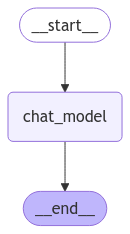

================================== Ai Message ==================================
Name: Assistant

So you said you were researching ocean mamals?
================================ Human Message =================================
Name: Lance

I'm looking for information on whales, specifically.One line answer.
================================== Ai Message ==================================

Whales are marine mammals that include baleen whales and toothed whales.


In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.state import CompiledStateGraph

#make node
def chat_model_node(state: MessagesState) -> MessagesState:
    response= {"messages":llm.invoke(state["messages"])}
    return response
#make graph
# graph: StateGraph = StateGraph(MessagesState)

# chat_model_node({"messages":messages})

builder: StateGraph = StateGraph(MessagesState)

builder.add_node("chat_model",chat_model_node)

builder.add_edge(START,"chat_model")
builder.add_edge("chat_model",END)

graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

#invoking
output=graph.invoke({"messages":messages})

for m in output['messages']:
    m.pretty_print()

In [ ]:
async for m in graph.astream_events({"messages":messages},version="v2"):
      print(m)
      print("\n=======================\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mamals?', additional_kwargs={}, response_metadata={}, name='Assistant', id='8b25d212-6105-4b60-a230-379564eb2fcc'), HumanMessage(content="I'm looking for information on whales, specifically.One line answer.", additional_kwargs={}, response_metadata={}, name='Lance', id='f03d01eb-45d2-4352-ab7d-32fc39f5d855')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '1459ecc4-deeb-4822-a5cf-e3edb9c77999', 'metadata': {}, 'parent_ids': []}


{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mamals?', additional_kwargs={}, response_metadata={}, name='Assistant', id='8b25d212-6105-4b60-a230-379564eb2fcc'), HumanMessage(content="I'm looking for information on whales, specifically.One line answer.", additional_kwargs={}, response_metadata={}, name='Lance', id='f03d01eb-45d2-4352-ab7d-32fc39f5d855')]}}, 'name': '__start_

#Reducer

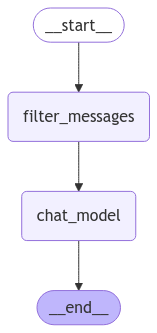

TypeError: RemoveMessage.__init__() missing 1 required positional argument: 'id'

In [ ]:
from langchain_core.messages import RemoveMessage

# node
def filter_messages(state:MessagesState) ->MessagesState:
    # Delete all but the 2 most recent messags
    deleted_messages=[RemoveMessage(content=m.content) for m in state["messages"][:-3]]
    print(deleted_messages)
    return {"messages": deleted_messages}

def chat_model_node(state: MessagesState) -> MessagesState:
    response= {"messages":llm.invoke(state["messages"])}
    return response

# build graph
builder: StateGraph=StateGraph(MessagesState)

builder.add_node("filter_messages",filter_messages)
builder.add_node("chat_model",chat_model_node)

builder.add_edge(START,"filter_messages")
builder.add_edge("filter_messages","chat_model")
builder.add_edge("chat_model",END)

graph:CompiledStateGraph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

messages=[AIMessage(f"How can I help you today?", name="Assistant",id="1")]
messages.append(HumanMessage(f"I'm looking for information about Agentic AI.One line answer.", name="Lance",id="2"))
messages.append(AIMessage(f"Agentic AI refers to artificial intelligence systems capable of independent goal-directed behavior.",name="Assistant",id="3"))
messages.append(HumanMessage(f"I'm looking for information about langgraph.short answer.", name="Lance",id="4"))
response=graph.invoke({"messages":messages})
for m in response['messages']:
    m.pretty_print()

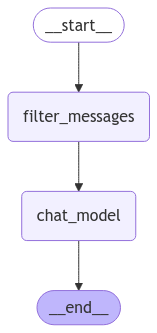

================================ Human Message =================================
Name: Lance

I'm looking for information about langgraph.short answer.
================================== Ai Message ==================================
Name: Assistant

LangChain's LangGraph is a knowledge base built from unstructured data, allowing for efficient querying and retrieval of information.  It uses vector databases to store and search embeddings of text.
================================ Human Message =================================
Name: Lance

make it esay to undertant.short answer.
================================== Ai Message ==================================
Name: Assistant

LangGraph lets you ask questions of a large collection of text documents and get relevant answers back.
-------------------------
================================ Human Message =================================
Name: Lance

Hi
================================== Ai Message ==================================
Name: Assi

In [ ]:
from langchain_core.messages import RemoveMessage

def filter_messages(state: MessagesState) -> MessagesState:
    """Filters messages, keeping only the last 3."""

    # Extract all messages except the last 3
    messages_to_keep = state["messages"][-4:]
    for m in messages_to_keep:
        m.pretty_print()
    print("-------------------------")
    # Create a new message list containing only the kept messages.
    return {"messages": messages_to_keep}

def chat_model_node(state: MessagesState) -> MessagesState:
    """Calls the language model."""
    # print(f"MessagesState: {state['messages']}")
    response = {"messages": llm.invoke(state["messages"])}
    return response

# build graph
builder: StateGraph = StateGraph(MessagesState)

builder.add_node("filter_messages", filter_messages)
builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "filter_messages")
builder.add_edge("filter_messages", "chat_model")
builder.add_edge("chat_model", END)

graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

# Example usage
messages_list = [
    HumanMessage(f"Hi",name="Lance"),
    AIMessage(f"How can I help you today?", name="Assistant"),
    HumanMessage(f"I'm looking for information about Agentic AI.One line answer.", name="Lance"),
    AIMessage(f"Agentic AI refers to artificial intelligence systems capable of independent goal-directed behavior.", name="Assistant"),
    HumanMessage(f"I'm looking for information about langgraph.short answer.", name="Lance"),
    AIMessage(f"LangChain's LangGraph is a knowledge base built from unstructured data, allowing for efficient querying and retrieval of information.  It uses vector databases to store and search embeddings of text.", name="Assistant"),
    HumanMessage(f"make it esay to undertant.short answer.", name="Lance"),
    AIMessage(f"LangGraph lets you ask questions of a large collection of text documents and get relevant answers back.", name="Assistant"),
]

response = graph.invoke({"messages": messages_list})
for m in response['messages']:
    m.pretty_print()

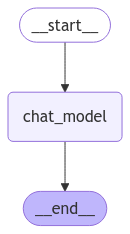

================================== Ai Message ==================================
Name: Assistant

LangChain's LangGraph is a knowledge base built from unstructured data, allowing for efficient querying and retrieval of information.  It uses vector databases to store and search embeddings of text.
================================ Human Message =================================
Name: Lance

make it esay to undertant.short answer.
================================== Ai Message ==================================
Name: Assistant

LangGraph lets you ask questions of a large collection of text documents and get relevant answers back.
================================ Human Message =================================
Name: Lance

what is the workflow in it.short answer.
-------------------------
================================ Human Message =================================
Name: Lance

Hi
================================== Ai Message ==================================
Name: Assistant

How can I 

In [ ]:
def chat_model_node(state: MessagesState) -> MessagesState:
    """Calls the language model."""
    messages_to_keep= state["messages"][-4:]
    for m in messages_to_keep:
        m.pretty_print()
    print("-------------------------")
    response = llm.invoke(messages_to_keep)
    # messages_to_keep.append(AIMessage(content=response,name="Assistant"))
    messages_to_keep.append(response)
    return {"messages":messages_to_keep}

# build graph
builder: StateGraph = StateGraph(MessagesState)

builder.add_node("chat_model", chat_model_node)


builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

# Example usage
messages_list = [
    HumanMessage(f"Hi",name="Lance"),
    AIMessage(f"How can I help you today?", name="Assistant"),
    HumanMessage(f"I'm looking for information about Agentic AI.One line answer.", name="Lance"),
    AIMessage(f"Agentic AI refers to artificial intelligence systems capable of independent goal-directed behavior.", name="Assistant"),
    HumanMessage(f"I'm looking for information about langgraph.short answer.", name="Lance"),
    AIMessage(f"LangChain's LangGraph is a knowledge base built from unstructured data, allowing for efficient querying and retrieval of information.  It uses vector databases to store and search embeddings of text.", name="Assistant"),
    HumanMessage(f"make it esay to undertant.short answer.", name="Lance"),
    AIMessage(f"LangGraph lets you ask questions of a large collection of text documents and get relevant answers back.", name="Assistant"),
    HumanMessage(f"what is the workflow in it.short answer.", name="Lance"),
]

response = graph.invoke({"messages": messages_list})
for m in response['messages']:
    m.pretty_print()

#Trim Messages

In [ ]:
from langchain_core.messages import trim_messages

def chat_model_node(state:MessagesState) ->MessagesState:
    messages=trim_messages(state["messages"],
                           max_tokens=100,
                           strategy="last",
                           token_counter=llm,
                           allow_partial=False)
    for m in messages:
        m.pretty_print()
    print("-------------------------")
    response={"messages":llm.invoke(messages)}
    return response

# messages = [
#     HumanMessage(f"Hi",name="Lance"),
#     AIMessage(f"How can I help you today?", name="Assistant"),
#     HumanMessage(f"I'm looking for information about Agentic AI.One line answer.", name="Lance")
#     ]

chat_model_node({"messages":messages_list})

================================ Human Message =================================
Name: Lance

I'm looking for information about langgraph.short answer.
================================== Ai Message ==================================
Name: Assistant

LangChain's LangGraph is a knowledge base built from unstructured data, allowing for efficient querying and retrieval of information.  It uses vector databases to store and search embeddings of text.
================================ Human Message =================================
Name: Lance

make it esay to undertant.short answer.
================================== Ai Message ==================================
Name: Assistant

LangGraph lets you ask questions of a large collection of text documents and get relevant answers back.
================================ Human Message =================================
Name: Lance

what is the workflow in it.short answer.
-------------------------


{'messages': AIMessage(content='Upload documents, LangGraph creates embeddings, you ask questions, it searches for the best matching embeddings, and provides answers based on those documents.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-9b2cdecb-8ab0-490b-9d6c-68b49842f748-0', usage_metadata={'input_tokens': 90, 'output_tokens': 29, 'total_tokens': 119, 'input_token_details': {'cache_read': 0}})}

# CHAT HISTORY SUMMARIZATION

In [5]:
!pip install --quiet -U langchain_google_genai langchain_core langgraph

from google.colab import userdata

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

from langchain_google_genai import ChatGoogleGenerativeAI
model: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash",api_key=GEMINI_API_KEY)
model.invoke("hi")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.16 which is incompatible.


AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-62e74566-98e8-431e-a55c-c047ffd2adb1-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [15]:
from langgraph.graph import MessagesState

class CustomMessageState(MessagesState):
    summary:str



In [16]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage,RemoveMessage, trim_messages

# Define the logic to call the function
def get_llm_response(state:CustomMessageState):
    #get summary key if exists else empty
    summary=state.get("summary","")

    if summary: #if summary has text
        #add summary to system message
        sys_msg=f"Summary of conversation upto now: {summary}"
        #append summary to any newer messages
        messages=[SystemMessage(content=sys_msg)]+state["messages"]

    else:
        messages=state["messages"]

    response=model.invoke(messages)
    return {"messages": response}


In [17]:
def summarize_conversation(state:CustomMessageState):
    summary=state.get("summary","")
    #create our summarization prompt
    if summary: #if summary has any content
        # summary already exists
        summary_message=(
            f"Summary of conversation upto now: {summary}\n\n"
            "Get all the important conversations from above"
        )
    else:
        summary_message="Create a summary of the conversation"

    #add prompt to our history
    messages_and_summary=state["messages"]+[HumanMessage(content=summary_message)]
    response=model.invoke(messages_and_summary)
    # get 2 the most recent messages
    last_message=[RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary":response.content,"messages":last_message}

In [18]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: CustomMessageState):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

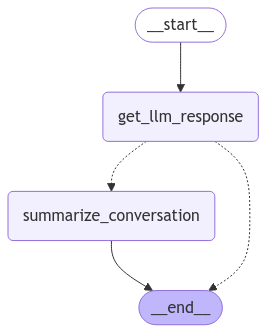

In [19]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.state import CompiledStateGraph

# Define a new graph
workflow: StateGraph = StateGraph(CustomMessageState)
workflow.add_node("get_llm_response", get_llm_response)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "get_llm_response")
workflow.add_conditional_edges("get_llm_response", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config)


input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)

input_message = HumanMessage(content="i like apples.!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! Nice to meet you.  How can I help you today?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Lance.
================================ Human Message =================================

i like apples.!
================================== Ai Message ==================================

That's great!  Apples are delicious.  What's your favorite kind of apple?


In [22]:
graph.get_state(config).values.get("summary","")

''

In [24]:
input_message=HumanMessage(content="what is Agentic ai?")
output=graph.invoke({"messages":[input_message]},config)
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is Agentic ai?
================================== Ai Message ==================================

Agentic AI refers to artificial intelligence systems that are capable of independent action and goal-directed behavior.  Unlike reactive AI, which simply responds to immediate inputs, agentic AI possesses the ability to:

* **Set goals:**  It can define its own objectives and work towards achieving them.
* **Plan and strategize:** It can create plans to accomplish its goals, adapting those plans as needed based on changing circumstances.
* **Learn and adapt:**  It can learn from its experiences and improve its performance over time.
* **Interact with the environment:** It can actively interact with its environment to gather information and achieve its objectives.
* **Make decisions:** It can make choices, often in uncertain or complex situations.


Essentially, agentic AI exhibits characteristics typicall

In [25]:
graph.get_state(config).values.get("summary","")

'The conversation began with introductions, where I identified the user as Lance.  Lance then expressed a liking for apples.  Finally, Lance asked for a definition of "Agentic AI," which I provided, explaining its characteristics of independent action, goal setting, planning, learning, and environmental interaction.'